In [2]:
import os
import os.path as op
import numpy as np
import matplotlib
import glob
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats, optimize
from pandas import DataFrame, Series
import seaborn as sns
import random as rd
import scipy.stats
import multiprocessing
from scipy.optimize import basinhopping
import random
from scipy.stats import norm
import statsmodels.api as sm
from scipy.stats import beta
from matplotlib import cm
from ipyparallel import Client
%matplotlib inline

//anaconda/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
rc = Client()

## Bandit functions

In [21]:
#drift rewards after each step with a reflecting boundary at .25 and .75
#This is a common feature of human and animal bandit tasks which keeps the task more engaging and encourages
#learning through the experiment.
def update_rewards(p_rew,rew_drift):
    p_rew.flags.writeable = True
    for i in range(len(p_rew)):
        shift = np.random.normal(0,rew_drift)
        new_p = p_rew[i] + shift 
        if (new_p > .75) or (new_p < .25): #reflecting boundaries
            p_rew[i] = p_rew[i] - shift
        else:
            p_rew[i] = new_p
    return p_rew

In [22]:
#Get the bandit probabilities over the whole simulation
def get_reward_trajectories(p_rew,ntrials):
    for i in range(ntrials):
        p_rew = np.vstack((p_rew,update_rewards(p_rew[-1,:],rew_drift)))
    return p_rew

In [23]:
#Given an action and the bandit probabilities, draw a reward according to reward probability functions
def get_reward(p_rew,action):
    return scipy.stats.bernoulli.rvs(p_rew[action])

## RL functions

In [24]:
#get probability of each action under the softmax
def get_prob(Q,m): 
    probs = map(lambda q: np.exp(q*m), Q)
    probs = probs / np.sum(probs)
    return probs

In [25]:
#pick an action according to softmax probs
def get_action(Q,m):
    
#     #randomly respond
#     if np.random.rand() < .1:
#         choice =  np.random.choice(a=range(len(Q)), p = [1.0/len(Q)]*len(Q))
    
#     else:
    choice = np.random.choice(a=range(len(Q)),p = get_prob(Q,m))   
    
    return choice

In [26]:
#perform rescorla-wagner update
def update_Q(rew,action,Q,alpha):
    delta = rew - Q[action]
    Q[action] = Q[action] + alpha*delta
    return Q

In [27]:
#executes each trial of the bandit
def take_step(alpha,m,p_rew,i,Q,output):

    action = get_action(Q,m) #take an action
    rew = get_reward(p_rew[i],action)#get a reward
    Q = update_Q(rew,action,Q,alpha) #update values

    #log what's happening
    output['rew'].append(rew)
    output['action'].append(action)
    output['Q'] = np.vstack([output['Q'],Q])

    return Q,output

In [28]:
def run_simulation(ntrials,alpha,m,p_rew):
    Q = [.5]*len(p_rew[-1,:]) #initialize q values to lie between 0 and 1
    output = {'action':[],'rew':[],'Q':np.array(Q)}

    for i in range(ntrials):
        Q,output = take_step(alpha,m,p_rew,i,Q,output)
    return Q,output

## We now have all the ingredients to run RL on a bandit task. Let's see an example

In [31]:
#define simulation parameters
ntrials = 1000
nbandits= 2
alpha = .3 #learning rate
m= 3.0 #inverse temperature
rew_drift = .025 #std of prob drift for each reward
p_rew_init = np.array([.35,.65],ndmin=2) #initialize bandit

#run simulations
p_rew = get_reward_trajectories(p_rew_init,ntrials)
Q,output = run_simulation(ntrials,alpha,m,p_rew)

//anaconda/lib/python2.7/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


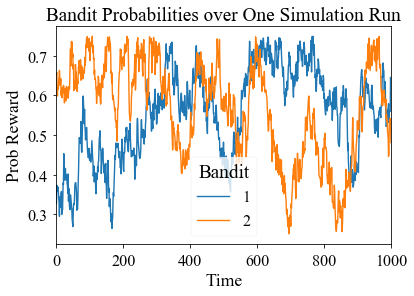

In [32]:
#visualize bandit probabilities
df =pd.DataFrame({'Prob Reward':p_rew.ravel(),'Bandit':[1,2]*(ntrials+1),
                  'Index':np.ones(len(p_rew.ravel())), 'Time':np.repeat(range(ntrials+1),nbandits)})
sns.tsplot(data=df,value = 'Prob Reward', condition = 'Bandit',time='Time',unit = 'Index')
plt.title('Bandit Probabilities over One Simulation Run')

## Now fit alpha

In [33]:
#returns the log likelihood for a sequence of choices given an alpha and m
def get_LL(params,actions,rewards,nbandits,rts = None, prior = False):
    alpha = scipy.stats.logistic.cdf(params[0]) #bound on 0,1
    m = scipy.stats.logistic.cdf(params[1])*10 #bound on [0,10]
    
    Q = [.5]*nbandits #initialize q values to lie between 0 and 1
    LL = 0
    Q_diffs = []
    for n,a in enumerate(actions):
        Q_diffs.append(sorted(Q)[-1] - sorted(Q)[-2]) #Q_value difference between best and second best option
        prob = get_prob(Q,m)[a]
        LL += np.log(prob)
        Q = update_Q(rewards[n],a,Q,alpha) #update Qs
     
    #add likelihood of rts if they exist
    if rts is not None:
        LL += sm.OLS(rts, Q_diffs).fit().llf

    #get prior likelihood
    if prior:
        log_prior = np.log(scipy.stats.beta.pdf(alpha,1.5,2))
        log_prior += np.log(scipy.stats.beta.pdf((m-.5)/10.0,2,6))
        LL += log_prior
    return LL*-1

In [34]:
ntrials = 500
alpha = .2
m = .6
p_rew = get_reward_trajectories(p_rew_init, ntrials)
Q,output = run_simulation(ntrials, alpha, m, p_rew)
rew = output['rew']
actions = output['action']

#simulate rts
diffs  = [sorted(row)[-1] - sorted(row)[-2] for row in output['Q']][:-1] #value difference
rts = [x + np.random.normal(0,5*np.std(diffs)) for x in diffs] #simulated rts
print scipy.stats.pearsonr(diffs,rts)
params = (0,-3)

#minimize
method = 'BFGS'
minimizer_kwargs = {"method": method, 'args':(actions,rew,3, None, False)}
res = basinhopping(get_LL, params, minimizer_kwargs=minimizer_kwargs,niter=1)

# ll_std = get_LL(, actions, rew, 3)
# ll_total = get_LL(, actions, rew, 3, rts)
# print 'choice', ll_std, 'rt', ll_total - ll_std, 'ratio', ll_std/(ll_total - ll_std)

(0.19307967988492314, 1.3765888644371872e-05)


0.415211770954


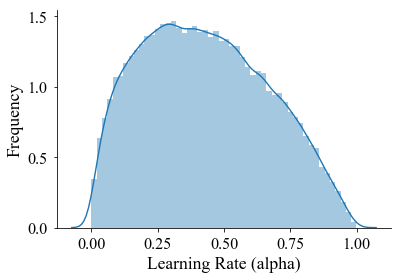

In [35]:
sns.set_context('paper',font_scale = 2,rc={"figure.figsize": (10, 10)})
sns.set_style({'font.family':'serif', 'font.serif':'Times New Roman'})

a = scipy.stats.beta.rvs(1.5, 2, size=100000)
sns.distplot(a)
sns.despine()
print np.median(a)
plt.xlabel('Learning Rate (alpha)')
plt.ylabel('Frequency')
plt.savefig(op.abspath('./paper/figures/alpha.svg'),dpi = 300)

2.78469248745


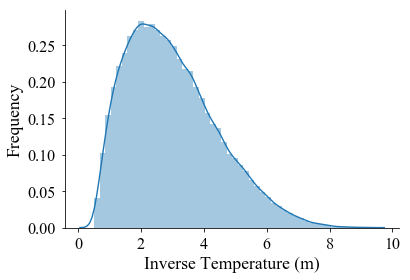

In [36]:
sns.set_context('paper',font_scale = 2,rc={"figure.figsize": (10, 10)})
sns.set_style({'font.family':'serif', 'font.serif':'Times New Roman'})


m = scipy.stats.beta.rvs(2, 6, size=100000)*10 + .5
sns.distplot(m)
sns.despine()
print np.median(m)
plt.xlabel('Inverse Temperature (m)')
plt.ylabel('Frequency')
plt.savefig(op.abspath('./paper/figures/temperature.svg'),dpi = 300)

In [47]:
def simulate_cohort(in_tuple):
    n, num_subjects, ntrials, rts, prior = in_tuple

    alphas = scipy.stats.beta.rvs(1.5, 2, size=num_subjects)
    ms = scipy.stats.beta.rvs(2, 6, size=num_subjects)*10 + .5
    ratio = [x/y for x,y in zip(alphas,ms)]
    
    fits = {'alpha':[],'m':[], 'ratio':[]}
    #loop through subjects
    for a,m in zip(alphas,ms):

        #simulate trajectory
        p_rew = get_reward_trajectories(p_rew_init, ntrials)
        nbandits = len(p_rew[-1,:])
        Q,output = run_simulation(ntrials, a, m, p_rew)
        rew = output['rew']
        actions = output['action']

        #simulate rts
        diffs  = [sorted(row)[-1] - sorted(row)[-2] for row in output['Q']][:-1] #value difference
        if rts:
            rts = [x + np.random.normal(0,5*np.std(diffs)) for x in diffs] #simulated rts
        else:
            rts = None

        #fit subject's data
        params = (0,-1)
        method = 'BFGS'
        minimizer_kwargs = {"method": method, 'args':(actions, rew, nbandits, rts, prior)}
        res = basinhopping(get_LL, params, minimizer_kwargs=minimizer_kwargs,niter=1)

        #store fitted parameters
        alpha = scipy.stats.logistic.cdf(res.x[0])
        m = scipy.stats.logistic.cdf(res.x[1])*10
        fits['alpha'].append(alpha)
        fits['m'].append(m)
        fits['ratio'].append(alpha/m)


    rho,p = scipy.stats.pearsonr(alphas,fits['alpha'])
    rho_m,p = scipy.stats.pearsonr(ms,fits['m'])
    rho_ratio,p = scipy.stats.pearsonr(ratio,fits['ratio'])

    fits['alpha_gt'] = alphas
    fits['m_gt'] = ms
    fits = pd.DataFrame(fits)
    
    #save
    suffix = ''
    if rts is not None:
        suffix = suffix + 'rts_'
    if prior:
        suffix = suffix + 'prior_'
    out_f = './simulations/' + '_'.join([str(n),str(ntrials),str(num_subjects)]) + '_fits_' + suffix + '.csv'
    fits.to_csv(out_f,index = False)
  
    out = pd.DataFrame({'rho_alpha':rho, 
                        'rho_m':rho_m,
                        'rho_ratio':rho_ratio,
                        'ntrials':ntrials,
                        'num_subs':num_subjects,}, index = [0])
    
    out_f = './simulations_subs_2bandits_pearson/' + '_'.join([str(n),str(ntrials),str(num_subjects)]) + '_corr_' + suffix + '.csv'
#     out.to_csv(out_f,index = False)
    return rho#, alphas,ms, fits

In [48]:
in_tuples = []
# nsubs = 25
ntrials = 200
for n in range(1000):
    for nsubs in [15, 25, 50, 100, 200]:
#     for ntrials in [100, 200, 300, 400, 500]:

        for rts in [True,False]:
            for prior in [True,False]:
                in_tuples.append((n,nsubs,ntrials, rts, prior))

In [324]:
# dview = rc[:]
# dview.block = True

# dview.push(dict(get_LL = get_LL,
#                 get_reward_trajectories = get_reward_trajectories,
#                 run_simulation = run_simulation,
#                 update_rewards = update_rewards,
#                 get_reward = get_reward,
#                 get_prob = get_prob,
#                 get_action = get_action,
#                 update_Q = update_Q,
#                 take_step = take_step,
#                 p_rew_init = p_rew_init,
#                 rew_drift = rew_drift
#                   ))
# dview.execute("import numpy as np")
# dview.execute("import os.path as op")
# dview.execute("import pandas as pd")
# dview.execute("import statsmodels.api as sm")
# with dview.sync_imports():
#     import os
#     import numpy
#     import scipy
#     import scipy.stats
#     from scipy.optimize import basinhopping
# dview.map_sync(simulate_cohort,in_tuples)

In [72]:
# res = glob.glob('./simulations/*_fits*.csv')
# fits = []
# for f in res:
#     sample = f.split('/')[2].split('_')[0]
#     ntrials = f.split('/')[2].split('_')[1]
#     nsubs = f.split('/')[2].split('_')[2]
#     in_df = pd.read_csv(f)
#     in_df['sample'] = sample
#     in_df['ntrials'] = int(ntrials)
#     in_df['nsubs'] = int(nsubs)
#     if 'prior' in f:
#         in_df['prior'] = 'prior' 
#     if 'rt' in f:
#         in_df['rt'] = 'rt' 
#     fits.append(in_df)
# fits = pd.concat(fits)

In [73]:
res = glob.glob('./simulations_trials_2bandits_pearson/*corr*.csv')
corr_trial = []
for f in res:
    sample = f.split('/')[2].split('_')[0]
    in_df = pd.read_csv(f)
    in_df['sample'] = sample
    in_df['type'] = 'std'
    if 'prior' in f:
        in_df['type'] =  in_df['type'] + '_prior' 
    if 'rt' in f:
        in_df['type'] = in_df['type'] + '_rt'
    corr_trial.append(in_df)
corr_trial = pd.concat(corr_trial).reset_index()

In [83]:
res = glob.glob('./simulations_subs_2bandits_pearson/*corr*.csv')
corr_sub = []
for f in res:
    sample = f.split('/')[2].split('_')[0]
    in_df = pd.read_csv(f)
    in_df['sample'] = sample
    in_df['type'] = 'std'
    if 'prior' in f:
        in_df['type'] =  in_df['type'] + '_prior' 
    if 'rt' in f:
        in_df['type'] = in_df['type'] + '_rt'
    corr_sub.append(in_df)
corr_sub = pd.concat(corr_sub).reset_index()

In [91]:
corr_sub = corr_sub.set_index(['num_subs','type']).sort_index()
corr_trial = corr_trial.set_index(['ntrials','type']).sort_index()

In [100]:
for nsubs in [15, 25, 50, 100, 200]:
    x = corr_sub.loc[(nsubs, 'std_prior_rt'),'rho_alpha']
    y = corr_sub.loc[(nsubs, 'std_rt'),'rho_alpha']
    
    print nsubs, scipy.stats.ttest_ind(x,y)[1]*10

15 4.3920357695e-15
25 2.01579851759e-10
50 2.27523344488e-34
100 2.08104677056e-61
200 2.46740908232e-104


In [99]:
for ntrials in [100, 200, 300, 400, 500]:
    x = corr_trial.loc[(ntrials, 'std_prior_rt'),'rho_alpha']
    y = corr_trial.loc[(ntrials, 'std_rt'),'rho_alpha']
    
    print ntrials, scipy.stats.ttest_ind(x,y)[1]*10

100 2.58073915509e-33
200 5.61300585916e-13
300 4.03223762127e-07
400 1.41518178e-10
500 0.000798837644732


In [80]:
corr.groupby(['ntrials','type']).mean()

level_0  index  num_subs  rho_alpha     rho_m  \
ntrials type                                                            
100     std            9998.169    0.0      25.0   0.663578  0.605587   
        std_prior     10096.263    0.0      25.0   0.792925  0.783736   
        std_prior_rt   9953.929    0.0      25.0   0.844941  0.804147   
        std_rt        10009.678    0.0      25.0   0.791162  0.709856   
200     std            9998.694    0.0      25.0   0.793440  0.768083   
        std_prior      9896.864    0.0      25.0   0.882478  0.879511   
        std_prior_rt  10037.496    0.0      25.0   0.918494  0.891602   
        std_rt        10021.806    0.0      25.0   0.896820  0.844867   
300     std            9993.170    0.0      25.0   0.849294  0.861272   
        std_prior      9896.132    0.0      25.0   0.912440  0.917087   
        std_prior_rt  10033.793    0.0      25.0   0.947251  0.927094   
        std_rt         9969.453    0.0      25.0   0.935660  0.892107   
400     std            9998.256    0.0      25.0   0.876149  0.898854   
        std_prior     10094.900    0.0      25.0   0.935788  0.936458   
        std_prior_rt   9957.688    0.0      25.0   0.962148  0.945568   
        std_rt        10011.815    0.0      25.0   0.947873  0.907747   
500     std            9992.985    0.0      25.0   0.897833  0.921187   
        std_prior     10095.818    0.0      25.0   0.947465  0.949127   
        std_prior_rt   9953.746    0.0      25.0   0.968445  0.955024   
        std_rt         9979.345    0.0      25.0   0.961693  0.920914   

                      rho_ratio  
ntrials type                     
100     std            0.352484  
        std_prior      0.576052  
        std_prior_rt   0.667072  
        std_rt         0.371912  
200     std            0.500234  
        std_prior      0.724827  
        std_prior_rt   0.804397  
        std_rt         0.592601  
300     std            0.591122  
        std_prior      0.782025  
        std_prior_rt   0.868597  
        std_rt         0.727010  
400     std            0.647873  
        std_prior      0.833327  
        std_prior_rt   0.897492  
        std_rt         0.785582  
500     std            0.690790  
        std_prior      0.863093  
        std_prior_rt   0.909628  
        std_rt         0.834758

In [327]:
#rename
cond_map = {'std_prior': 'Bayesian Prior', 'std': 'Standard Fit',
            'std_rt': "Reaction Time",'std_prior_rt': 'Prior and Reaction Time' }
corr['condition'] = [cond_map[x] for x in corr['type']]

#reorder
cond_map = {'Bayesian Prior': 3,
            'Standard Fit': 4,
            "Reaction Time": 2,
            'Prior and Reaction Time': 1}

s = pd.DataFrame({'condition':corr['condition'].values})
corr['sort_index'] =  s['condition'].apply(lambda x: cond_map[x])

corr = corr.sort_values(by = ['sort_index']).reset_index()


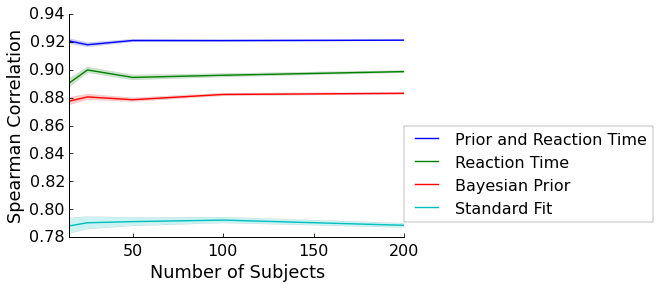

In [334]:
sns.set_context(context = 'paper', font_scale = 2)
corr = corr.sort_index()
sns.tsplot(time = 'num_subs',
           value = 'rho_alpha',
           condition = 'condition',
           unit = 'sample',
           data = corr)
sns.despine()
plt.ylabel('Pearson Correlation')
plt.xlabel('Number of Subjects')
plt.legend(bbox_to_anchor=(1, .5), loc=2, borderaxespad=0.)
plt.savefig('./fits_10000samples_subs_2bandits.svg', dpi = 300)

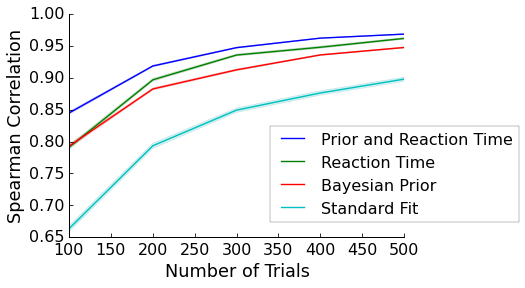

In [311]:
sns.set_context(context = 'paper', font_scale = 2)
corr = corr.sort_index()
sns.tsplot(time = 'ntrials',
           value = 'rho_alpha',
           condition = 'condition',
           unit = 'sample',
           data = corr)
sns.despine()
plt.ylabel('Pearson Correlation')
plt.xlabel('Number of Trials')
plt.legend(bbox_to_anchor=(.6, .5), loc=2, borderaxespad=0.)
plt.savefig('./fits_10000samples_trials_2bandits.svg', dpi = 300)

In [341]:
diffs = np.random.normal(0,1,200)
rts = [x + np.random.normal(0,5*np.std(diffs)) for x in diffs] #simulated rts

diffs_distorted = [x + np.random.normal(0,np.std(diffs)) for x in diffs] #simulated rts

print scipy.stats.pearsonr(diffs,rts)
print scipy.stats.pearsonr(diffs_distorted,diffs)
print scipy.stats.pearsonr(diffs_distorted,rts)

(0.21711573704768095, 0.0020140235656361236)
(0.68280263454454115, 8.418306450171436e-29)
(0.12838983590878583, 0.070012247461091498)


In [342]:
.23*.79

0.18170000000000003